# Recurrent Neural Net (RNN) w/Series Expression

The previous example showed some improvements we can make, but there are always more things we can do to make it easier for the model to detect fraud. Here are a couple of things we can do;

- Add more derived features. For instance the fact that we had a round amount gets lost because of scaling and binning. Such a features can be added with a `FeatureExpression` it only depends on a single transactions
- Some derived features might depend on the series. For instance we could argue that the time between transactions is a notion that gets lost in the 'stacking' of the series, this can not be calculated with just one transaction, we need a set of them. We have a `FeatureExpressionSeries` to help with that. A `FeatureExpressionSeries` works similar to a regular `FeatureExpression` but is executed as the series are built. While the regular `FeatureExpression` is built prior to constructing the Series. The input to a `FeatureExpressionSeries` is the ordered set of transaction fields as DataFrame. This syntax may seem a bit awkward, but it allows us to run highly efficient vectorized code on the DataFrames, this takes a fraction of the time Python would need natively to loop over the elements.

We will not use the round amount example as there are barely round amounts in the data-set, a bit unrealistic. But we'll add a date-delta and we'll use the scaled amount again rather than using a binned amount, so as to mix things up a bit.

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

In [1]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

A new function had been adeed to calculate the time-delta between consequent payments for the same customer. It's input will be a Panda's DataFrame and it will output a normalized (to 190 days) time-delta. Remember that __normalizing__ the data is important for Neural Nets, it allows them to converge much faster.

The new function is used in the `FeatureExpressionSeries` feature named __'date-time-delta'__.

The Customer data has a similar shape as the previous example, we can see however that the series output is different. We now have 3 Numpy Arrays in the series list instead of 2 in the previous examples 
- The first Numpy is of type `float32` and has a Rank-3. The first dimension is the batch, the second dimension is the time and the third dimension are the scaled amount and time-delta respetively.
- The second Numpy is of type `int16` and had a Rank-3. The first dimension is the batch, the second dimension is the time and the third dimension are the 'category' and 'merchant' indexes.
- The third Numpy are te labels. Similar to the previous example.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
# Base Features
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

# Function to calculate the date and time from the step
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

# Function to calculate the time difference between all rows and normalise
def calc_delta(dates):
    if isinstance(dates, pd.DataFrame):
        res = dates.diff() / np.timedelta64(190, 'D')
        res = res.fillna(0).abs()
        return res
    else:
        # There was only 1 row
        return 0

# Derived Features
date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])
date_time_delta = ft.FeatureExpressionSeries('delta', ft.FEATURE_TYPE_FLOAT_32, calc_delta, [date_time])
age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

cust_learn_features = ft.TensorDefinition(
    'customer_learning', 
    [
        age_i,
        gender_i,
    ])

trx_learn_features = ft.TensorDefinition(
    'transaction_learning', 
    [
        customer,
        date_time,
        merchant_i,
        category_i,
        amount_scale,
        date_time_delta
    ])


label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([cust_learn_features, trx_learn_features, label])

with en.EnginePandasNumpy(num_threads=8) as e:
    cust_df     = e.from_csv(cust_learn_features, file, inference=False)
    cust_list   = e.to_numpy_list(cust_learn_features, cust_df)
    series_list = e.to_series_stacked(
        trx_learn_features, file, key_feature=customer, time_feature=date_time, window=5, inference=False
    )
    lb_df       = e.from_csv(label, file, inference=False)
    lb_np       = e.to_numpy_list(label, lb_df)
    
print('Customer data Shapes')
print(cust_list.shapes)
print(cust_list.dtype_names)
print('Series Shapes')
print(series_list.shapes)
print(series_list.dtype_names)
print('Label Shapes')
print(lb_np.shapes)
print(lb_np.dtype_names)

data_list = en.NumpyList(cust_list.lists + series_list.lists + lb_np.lists)
print('Numpy Shapes')
print(data_list.shapes)

2021-09-27 20:27:41.314 d373c7.engines.common          INFO     Start Engine...
2021-09-27 20:27:41.314 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-27 20:27:41.314 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-27 20:27:41.321 d373c7.engines.panda_numpy     INFO     Building Panda for : customer_learning from file ../../../../data/bs140513_032310.csv
2021-09-27 20:27:41.468 d373c7.engines.panda_numpy     INFO     Building Panda for : <Source_Derive_Source> from DataFrame. Inference mode <False>
2021-09-27 20:27:41.469 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Source_Derive_Source
2021-09-27 20:27:41.469 d373c7.engines.panda_numpy     INFO     Done creating Source_Derive_Source. Shape=(594643, 2)
2021-09-27 20:27:41.480 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: customer_learning
2021-09-27 20:27:41.482 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2021-09-

Customer data Shapes
[(594643, 2)]
['int8']
Series Shapes
[(594643, 5, 2), (594643, 5, 2)]
['int16', 'float32']
Label Shapes
[(594643,)]
['int8']
Numpy Shapes
[(594643, 2), (594643, 5, 2), (594643, 5, 2), (594643,)]


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [5]:
test_records = 100000
val_records  = 30000 
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(434643, 2), (434643, 5, 2), (434643, 5, 2), (434643,)]
Validation Data shapes [(30000, 2), (30000, 5, 2), (30000, 5, 2), (30000,)]
Test Data shapes [(100000, 2), (100000, 5, 2), (100000, 5, 2), (100000,)]
Done


## Set-up Devices

In [6]:
device, cpu = pt.init_devices()

2021-09-27 20:28:08.732 d373c7.pytorch.common          INFO     Torch Version : 1.9.0+cu111
2021-09-27 20:28:08.781 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-09-27 20:28:08.781 d373c7.pytorch.common          INFO     Cuda Version  : 11.1


## Build the model

> In this example we still use a `GeneratedClassifier` model. We give it the TensorDefinitionMulti object containing our various tensor definitions. As there is now TensorDefinition that has 3D data (our transaction series; which has Batch x Series x Feature shape), the model will use a layer capable of handling 3D Tensors. We ask it to use *16* recurrent features and add 1 layer of *8* linear features after that.

In [7]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)
train_sampler = pt.ClassSamplerMulti(model_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)


# Create a Model
m = pm.GeneratedClassifier(model_features, recurrent_features=16, linear_layers=[8])

print(m)

GeneratedClassifier(
  Number of parameters : 5268. Loss : SingleLabelBCELoss,  mean
  (streams): ModuleList(
    (0): TensorDefinitionHead(
      lcs=['Categorical']
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(9, 4)
          (1): Embedding(5, 4)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
    (1): Sequential(
      (transaction_learning): TensorDefinitionHead(
        lcs=['Continuous', 'Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(51, 25)
            (1): Embedding(16, 7)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (Recurrent): LSTMBody(
        (rnn): LSTM(34, 16, batch_first=True)
      )
    )
  )
  (tail): TailBinary(
    (layers): Sequential(
      (tail_lin_01): Linear(in_features=58, out_features=8, bias=True)
      (tail_act_01): ReLU()
      (tail_dropout_01): Dropout(p=0.1, inplace=False)
      

Graphically that model looks as depicted below. A tad more complicated than the previous one. 

Breaking it down we see that the main difference with the previous example is in the Head(0). I.e. the head of the __Transactional__ features. Not all of them are categorical, we have the delta and amount which are continuous. Continous variables do not run through embeddings, so the Stacked Transactions Series is split into Categorical and Continuous features. 

The categorical features go through embedding like previously, the output of that is a *Rank-2* Tensor with a first dimension of 'time' and the second dimension of __32 features__ (The sum of the embedding output dimensions).

The two continuous features plain by-pass the Embedding and get concatenated to the embedding output tensor allong the 'features' axis. That gives us a *Rank-2* tensor which has 'time' in the first dimension and now has __34 features__ as second axis. The 34 are fed to the `LSTM` layer just like before.

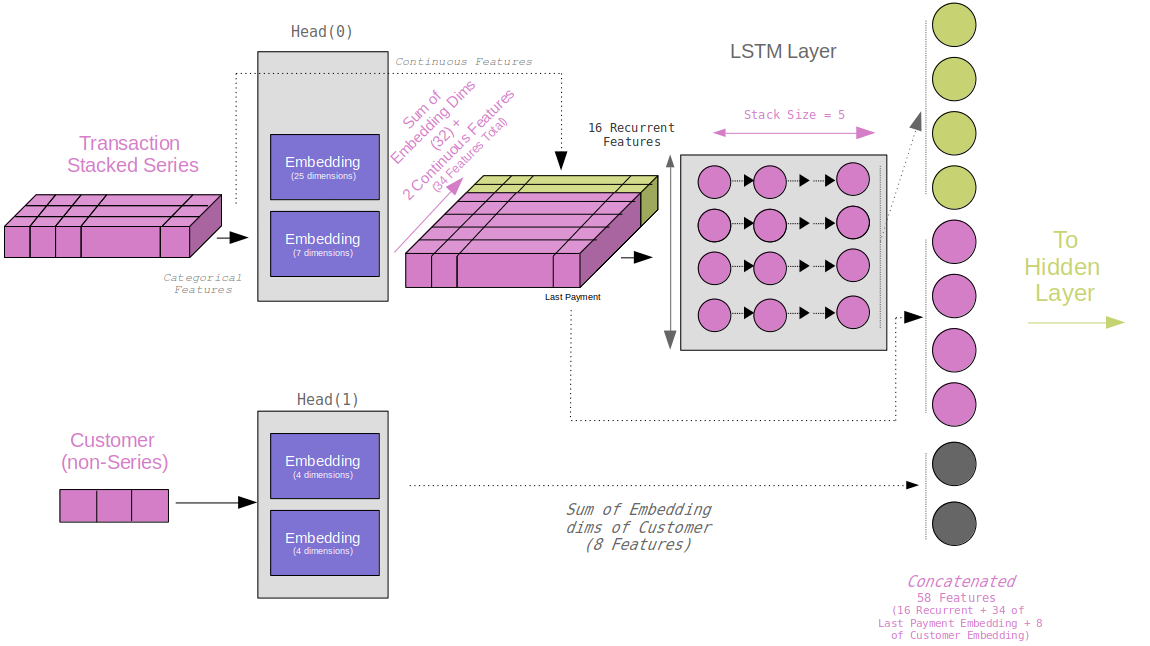

## Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2021-09-27 20:29:36.948 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 278.81it/s]
2021-09-27 20:29:40.025 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


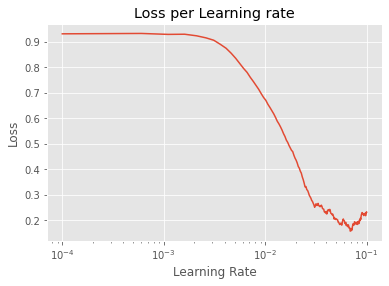

In [8]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

### Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 010/010: 100%|██████████| 3631/3631 [00:09<00:00, 366.19it/s, train_loss=0.0729, train_acc=0.976, val_loss=0.0569, val_acc=0.978]


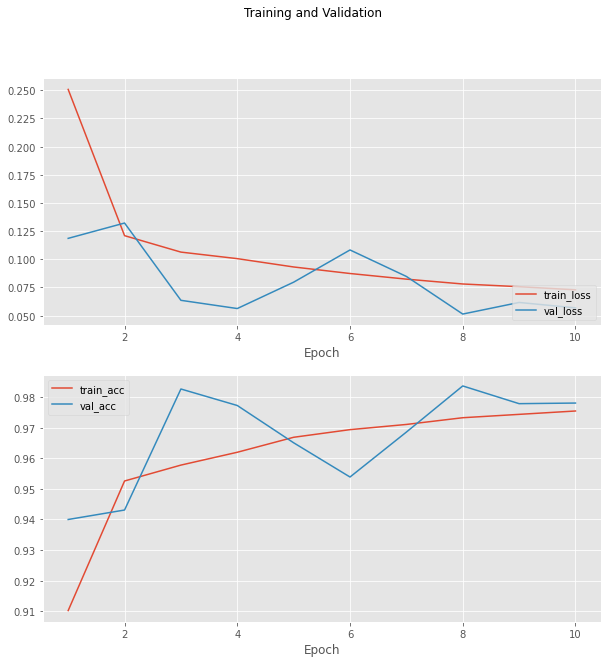

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data

> Test the model on the test set, it is data that was not seen during training and allows us to validate model results. Overall this model behaves very nicely. It's one of the better performing models. We'd have to run more experiments to find exactly which change impacted the results (using the scales rather than binned amount vs. including the date-delta). In real life one would expect the delta to have a fairly big impact in some credit card fraud scenario's. Though with this data, it probably does not matter all that much as the orginal step size is really coarse.

Testing in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 853.41it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     98926
         1.0       0.36      0.98      0.53      1074

    accuracy                           0.98    100000
   macro avg       0.68      0.98      0.76    100000
weighted avg       0.99      0.98      0.99    100000


auc score : 0.9975
ap score  : 0.8665
-----------------------------------------------------


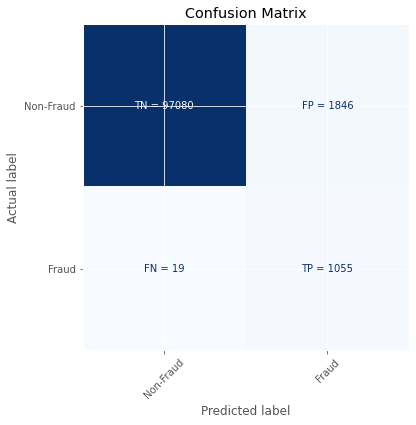

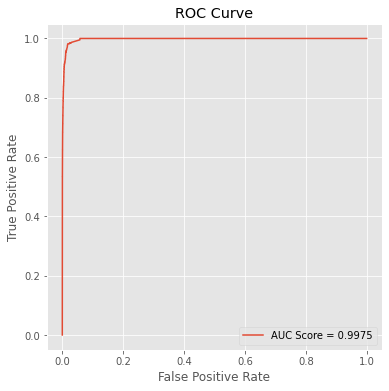

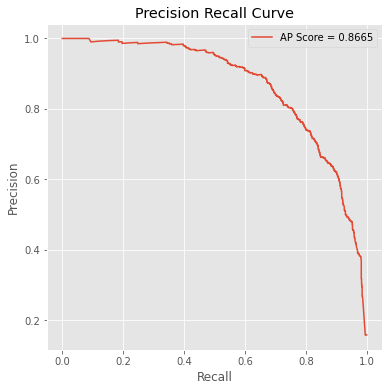

In [10]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

## Plot Embeddings
> As we have embeddings in this model, we can visualize them. Interesting enough we get more variance in the first component as compared to the previous examples.

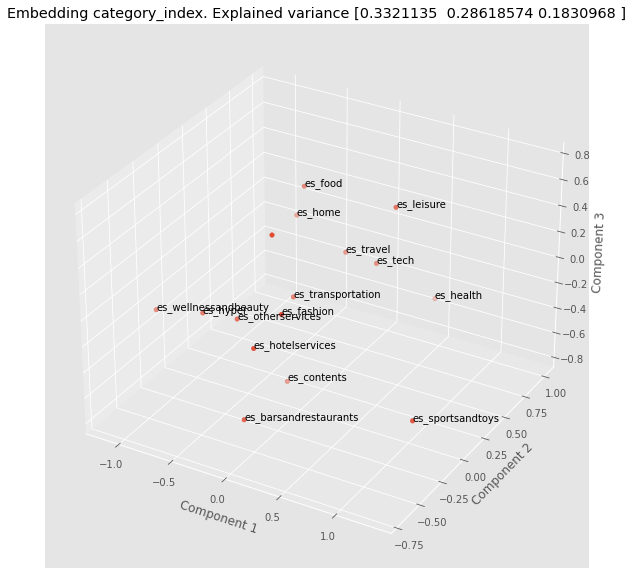

In [11]:
w = m.embedding_weight(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

# Conclusion
Most of the previous examples were mainly to introduce the concepts and would probably not get good results on real life data. 

With this example we are now in a place where we get to models we could be using in __real-life scenario's__. We'd have more features, would add some more derived features, make the series longer, maybe more heads, but the gist and architecture of this model should be usable in an actual Financial Crime detection scenario.